In [1]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from random import seed,sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc,\
precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
import seaborn as sns
sns.set()
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
# adding feature type1
df = pd.read_csv('../PS_20174392719_1491204439457_log.csv')

In [3]:
# From the dataset, it seems that fraud transactions only occur when the transaction type is CASH_OUT or TRANSFER
# Subsetting data into observations with fraud and valid transactions:
df = df[(df["type"] == "CASH_OUT") | (df["type"] == "TRANSFER")]

In [4]:
df["errorBalanceOrg"] = df.newbalanceOrig + df.amount - df.oldbalanceOrg
df["errorBalanceDest"] = df.oldbalanceDest + df.amount - df.newbalanceDest

fraud = df[df["isFraud"] == 1]
valid = df[df["isFraud"] == 0]

In [5]:
# getting rid of nameOrig and nameDest column.
names = ["nameOrig", "nameDest"]
fraud = fraud.drop(names, 1)
valid = valid.drop(names, 1)
df = df.drop(names, 1)


In [6]:
df1 = df.copy()

# adding feature HourOfDay to Dataset1
df1["HourOfDay"] = np.nan # initializing feature column
df1.HourOfDay = df.step % 24

In [7]:
df2 = df1.copy()
df2 = pd.get_dummies(df1, prefix = ['type'])

In [8]:
# Setting random_state and seed so that the training/testing splits and model results are reproducible
RandomState = 42
seed(21)

# 42 is used often due to Hitchhiker's Guide to the Galaxy, I will use a number that a far smaller group may understand.
# Not that the actual number doesn't matter and is only used to make sure results are reproducible.
# Something about 42: https://grsahagian.medium.com/what-is-random-state-42-d803402ee76b

# creating training and testing 
X = df2.drop("isFraud", 1)
y = df2.isFraud
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Normalizing data so that all variables follow the same scale (0 to 1)
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Model 1: Artificial Neural Networks

In [9]:
ncols = len(X.columns)
hidden_layers = (ncols, ncols, ncols)
max_iter = 1000
MLP = MLPClassifier(hidden_layer_sizes = hidden_layers, max_iter = 1000, random_state = RandomState)

# training model
MLP.fit(X_train, y_train)



MLPClassifier(hidden_layer_sizes=(12, 12, 12), max_iter=1000, random_state=42)

In [10]:
ncols = len(X.columns)
hidden_layers = (ncols, ncols, ncols)
max_iter = 1000
MLP = MLPClassifier(hidden_layer_sizes = hidden_layers, max_iter = 1000, random_state = RandomState)

# training model
MLP.fit(X_train, y_train)

# evaluating model on how it performs on balanced datasets
predictionsMLP = MLP.predict(X_test)
CM_MLP = confusion_matrix(y_test,predictionsMLP)
CR_MLP = classification_report(y_test, predictionsMLP)
fprMLP, recallMLP, threshcoldsMLP = roc_curve(y_test, predictionsMLP)
AUC_MLP = auc(fprMLP, recallMLP)

resultsMLP = {"Classification Report":CR_MLP, "Area Under Curve":AUC_MLP}

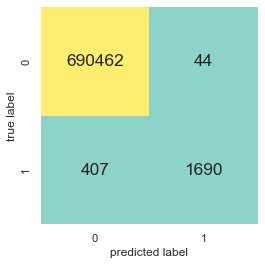

In [11]:
mat = confusion_matrix(y_test, predictionsMLP)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"}, cmap="Set3")
ax.set(xlabel = "predicted label", ylabel = "true label")
fig.savefig('MLP.png', transparent=True)

In [12]:
for measure in resultsMLP:
    print(measure,": \n", resultsMLP[measure])

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690506
           1       0.97      0.81      0.88      2097

    accuracy                           1.00    692603
   macro avg       0.99      0.90      0.94    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve : 
 0.9029247439798804


### Model 2: Random Forest

In [13]:
# Train model
parametersRF = {'n_estimators':15, 'oob_score':True, 'class_weight': "balanced", 'n_jobs':-1, 'random_state':RandomState}
RF = RandomForestClassifier(**parametersRF)
fitted_vals = RF.fit(X_train, y_train)

# Predict on testing set
predictionsRF = RF.predict(X_test)

# Evaluating model
CM_RF = confusion_matrix(y_test,predictionsRF)
CR_RF = classification_report(y_test,predictionsRF)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, predictionsRF)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Classification Report":CR_RF,"Area Under Curve":AUC_RF}

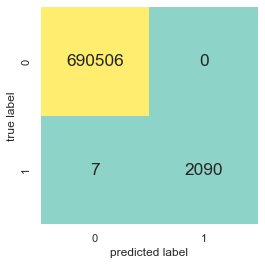

In [14]:
mat = confusion_matrix(y_test, predictionsRF)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"}, cmap="Set3")
ax.set(xlabel = "predicted label", ylabel = "true label")
fig.savefig('RandomForest.png', transparent=True)

In [15]:
for measure in resultsRF:
    print(measure,": \n", resultsRF[measure])

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690506
           1       1.00      1.00      1.00      2097

    accuracy                           1.00    692603
   macro avg       1.00      1.00      1.00    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve : 
 0.9983309489747259


### Model 3: XGB trees

In [16]:
# Train model
weights = (y == 0).sum() / (1.0 * (y == 1).sum()) # for unbalanced datasets, these weights are recommended
parametersXGB = {'max_depth':3, 'scale_pos_weight': weights, 'n_jobs':-1, 'random_state':RandomState, 'learning_rate':0.1}
XGB = XGBClassifier(**parametersXGB)

fitted_vals = XGB.fit(X_train, y_train)

# Predict on testing set
predictionsXGB = XGB.predict(X_test)

# Evaluating model
CM_XGB = confusion_matrix(y_test,predictionsXGB)
CR_XGB = classification_report(y_test, predictionsXGB)
fprXGB, recallXGB, thresholds_XGB = roc_curve(y_test, predictionsXGB)
AUC_XGB = auc(fprXGB, recallXGB)
resultsXGB = {"Classification Report":CR_XGB, "Area Under Curve":AUC_XGB}

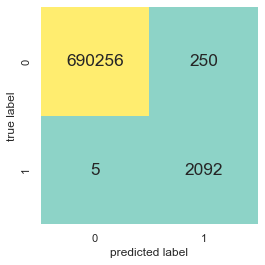

In [17]:
mat = confusion_matrix(y_test, predictionsXGB)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"}, cmap="Set3")
ax.set(xlabel = "predicted label", ylabel = "true label")
fig.savefig('XGBtrees.png', transparent=True)

In [18]:
for measure in resultsXGB:
    print(measure,": \n", resultsXGB[measure])

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690506
           1       0.89      1.00      0.94      2097

    accuracy                           1.00    692603
   macro avg       0.95      1.00      0.97    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve : 
 0.9986267940288324


### Comparing performances

Clearly, the random forest an the XGB trees performed better than the neural networks.  
Now we need to find out which is better between random forest and XGB trees.

In [19]:
# Comepare theri confusion matrices with their number of wrong predictions.
print("Number of valid transactions labelled as fraudulent by Random Forest: \n", CM_RF[0,1])
print("Number of valid transactions labelled as fraudulent by XGB trees: \n", CM_XGB[0,1])

Number of valid transactions labelled as fraudulent by Random Forest: 
 0
Number of valid transactions labelled as fraudulent by XGB trees: 
 250


> On the basis on limiting the amount of valid transaction labelled as fraudulent, the Random Forest performed better.

In [20]:
print("Number of fraud transactions labelled as valid by Random Forest: \n", CM_RF[1,0])
print("Number of fraud transactions labelled as valid by XGB trees: \n", CM_XGB[1,0])

Number of fraud transactions labelled as valid by Random Forest: 
 7
Number of fraud transactions labelled as valid by XGB trees: 
 5


> On the basis on limiting the amount of fraudulent transactions labelled as fraudulent, the XGB trees performed better.

Based purely on the results on the confusion matrix, the better model is decided by which model incurs the lowest costs.  

Next, we compared the classification reports.

In [21]:
print("Note: Scores in the same vertical level as 0 are scores for valid transactions. \n      Scores in the same vertical level as 1 are scores for fraudulent transactions. \n")
print("Classification Report of Random Forest: \n", CR_RF)
print("Classification Report of XGB trees: \n", CR_XGB)

Note: Scores in the same vertical level as 0 are scores for valid transactions. 
      Scores in the same vertical level as 1 are scores for fraudulent transactions. 

Classification Report of Random Forest: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690506
           1       1.00      1.00      1.00      2097

    accuracy                           1.00    692603
   macro avg       1.00      1.00      1.00    692603
weighted avg       1.00      1.00      1.00    692603

Classification Report of XGB trees: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690506
           1       0.89      1.00      0.94      2097

    accuracy                           1.00    692603
   macro avg       0.95      1.00      0.97    692603
weighted avg       1.00      1.00      1.00    692603



The Random Forest performed slightly better in terms of their precision score for fraudulent transactions.  

This means that there are considerably less valse positives in the Random Forest than in the XGB model.

Based on the classification report, the Random Forest is superior.

Next, we compared the AUC's (area under the curve).

Note that the ideal AUC is then 1 (all transactions predicted as valid are actually valid).


Receiver Operating Characteristic Curves for Random Forests and Extreme Gradient Boosted Trees: 



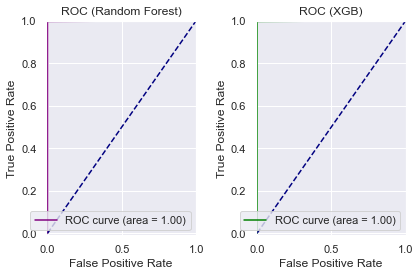


AUC of Random Forest: 
 0.9983309489747259

AUC of XGB trees: 
 0.9986267940288324


In [22]:
print("\nReceiver Operating Characteristic Curves for Random Forests and Extreme Gradient Boosted Trees: \n")
plt.subplot(1, 2, 1)
plt.plot(fprRF, recallRF, color='purple', label='ROC curve (area = %0.2f)' % AUC_RF)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Random Forest)')
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)
plt.plot(fprRF, recallRF, color='green', label='ROC curve (area = %0.2f)' % AUC_RF)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (XGB)')
plt.legend(loc="lower right")
plt.savefig('AUC.png', transparent=True)

plt.tight_layout()
plt.show()




print("\nAUC of Random Forest: \n", AUC_RF)
print("\nAUC of XGB trees: \n", AUC_XGB)

For all practical purposes, they are essentially the same.

Since the cost of resolving over a 100 valid transactions labelled as fraudulent would exceed the cost of resolving a handful more fraudulent transactions that have been passed opp as valid, the Random Forest might be the superior choice.

---
#### The most important in classifying transactions.

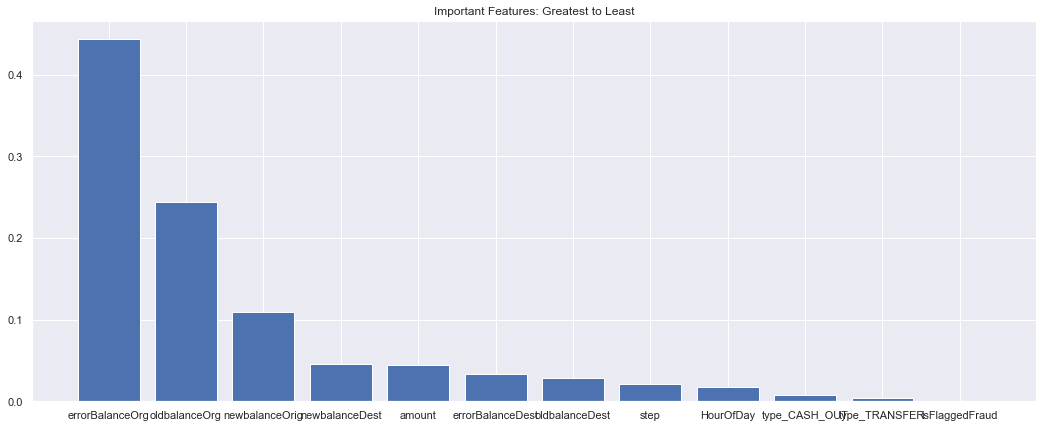

In [23]:
x = np.arange(ncols)

# getting importances of features
importances = RF.feature_importances_

# getting the indices of the most important feature to least important
sort_ind = np.argsort(importances)[::-1]
plt.figure(figsize=(18,7))
plt.bar(x, importances[sort_ind])
plt.xticks(x,tuple(X.columns.values[sort_ind]))
plt.title("Important Features: Greatest to Least")
plt.savefig('importances.png', transparent=True)
plt.show()

It seems that errorBalanceOrg ended by the most important feature by far for classifying transactions followed by oldBalanceOrg and newBalanceOrig.